# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

dpi = 50

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/MP_dataset',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

    # Defining target factor
    target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

Number of training   graphs: 36000
Number of validation graphs: 4500
Number of testing    graphs: 4500


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [7]:
model = clm.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

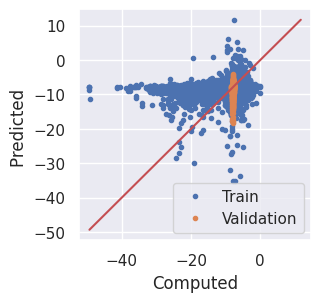

Epoch: 1, Train MAE: 3.3769, Val MAE: 0.9090
Epoch: 2, Train MAE: 3.2790, Val MAE: 0.9428
Epoch: 3, Train MAE: 3.2702, Val MAE: 0.9153
Epoch: 4, Train MAE: 3.2543, Val MAE: 0.9858
Epoch: 5, Train MAE: 3.2414, Val MAE: 1.1654


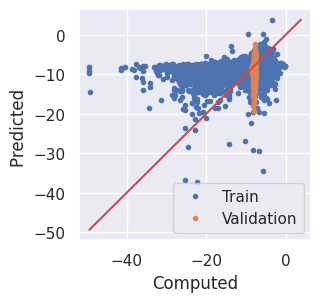

Epoch: 6, Train MAE: 3.2237, Val MAE: 1.1080
Epoch: 7, Train MAE: 3.2175, Val MAE: 1.1400
Epoch: 8, Train MAE: 3.2101, Val MAE: 1.1023
Epoch: 9, Train MAE: 3.1978, Val MAE: 1.1578
Epoch: 10, Train MAE: 3.1900, Val MAE: 1.1193


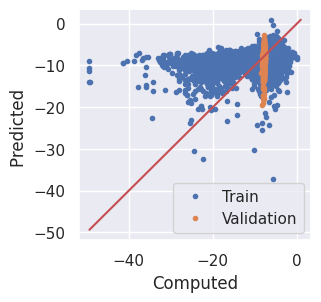

Epoch: 11, Train MAE: 3.1932, Val MAE: 1.2230
Epoch: 12, Train MAE: 3.1773, Val MAE: 1.1114
Epoch: 13, Train MAE: 3.1659, Val MAE: 1.1914
Epoch: 14, Train MAE: 3.1568, Val MAE: 1.2347
Epoch: 15, Train MAE: 3.1348, Val MAE: 1.3148


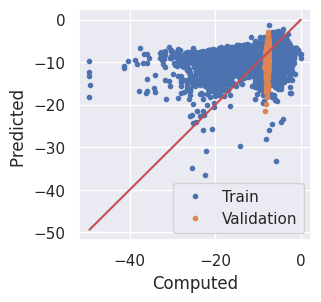

Epoch: 16, Train MAE: 3.1434, Val MAE: 1.1839
Epoch: 17, Train MAE: 3.1359, Val MAE: 1.1901
Epoch: 18, Train MAE: 3.1247, Val MAE: 1.2617
Epoch: 19, Train MAE: 3.1182, Val MAE: 1.2675
Epoch: 20, Train MAE: 3.1055, Val MAE: 1.2829


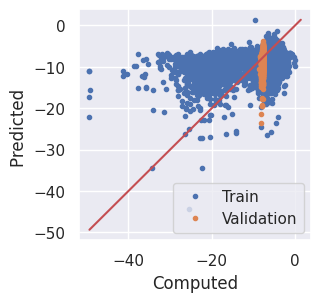

Epoch: 21, Train MAE: 3.1131, Val MAE: 1.2097
Epoch: 22, Train MAE: 3.1027, Val MAE: 1.2506
Epoch: 23, Train MAE: 3.0939, Val MAE: 1.1070
Epoch: 24, Train MAE: 3.1062, Val MAE: 1.3511
Epoch: 25, Train MAE: 3.0676, Val MAE: 1.3446


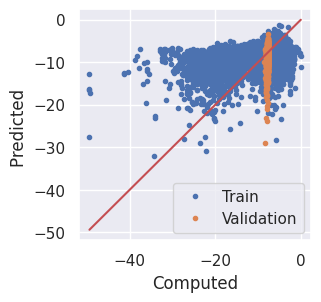

Epoch: 26, Train MAE: 3.0749, Val MAE: 1.3862
Epoch: 27, Train MAE: 3.0729, Val MAE: 1.3995
Epoch: 28, Train MAE: 3.0603, Val MAE: 1.4232
Epoch: 29, Train MAE: 3.0697, Val MAE: 1.4550
Epoch: 30, Train MAE: 3.0460, Val MAE: 1.3830


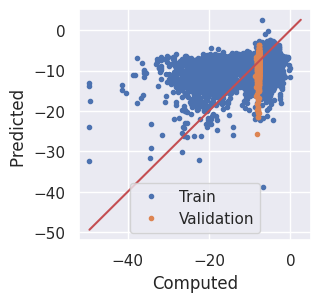

Epoch: 31, Train MAE: 3.0445, Val MAE: 1.3476
Epoch: 32, Train MAE: 3.0337, Val MAE: 1.4030
Epoch: 33, Train MAE: 3.0382, Val MAE: 1.4248
Epoch: 34, Train MAE: 3.0496, Val MAE: 1.4317
Epoch: 35, Train MAE: 3.0193, Val MAE: 1.5587


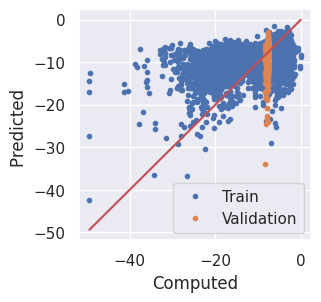

Epoch: 36, Train MAE: 3.0084, Val MAE: 1.4624
Epoch: 37, Train MAE: 3.0217, Val MAE: 1.4695
Epoch: 38, Train MAE: 3.0102, Val MAE: 1.5988
Epoch: 39, Train MAE: 3.0001, Val MAE: 1.5770
Epoch: 40, Train MAE: 2.9955, Val MAE: 1.4688


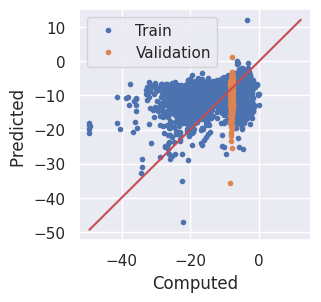

Epoch: 41, Train MAE: 3.0230, Val MAE: 1.5384
Epoch: 42, Train MAE: 2.9988, Val MAE: 1.6304
Epoch: 43, Train MAE: 2.9875, Val MAE: 1.4266
Epoch: 44, Train MAE: 2.9746, Val MAE: 1.4843
Epoch: 45, Train MAE: 2.9886, Val MAE: 1.6350


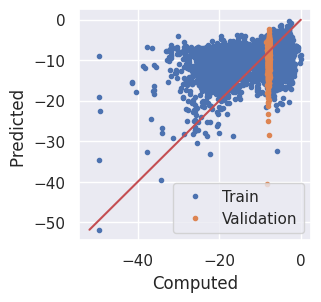

Epoch: 46, Train MAE: 2.9707, Val MAE: 1.5054
Epoch: 47, Train MAE: 2.9754, Val MAE: 1.5810
Epoch: 48, Train MAE: 2.9802, Val MAE: 1.6135
Epoch: 49, Train MAE: 2.9704, Val MAE: 1.5824
Epoch: 50, Train MAE: 2.9783, Val MAE: 1.6300


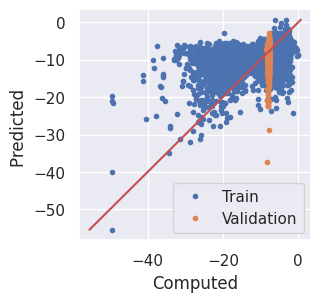

Epoch: 51, Train MAE: 2.9522, Val MAE: 1.5802
Epoch: 52, Train MAE: 2.9589, Val MAE: 1.6656
Epoch: 53, Train MAE: 2.9435, Val MAE: 1.5849
Epoch: 54, Train MAE: 2.9713, Val MAE: 1.6259
Epoch: 55, Train MAE: 2.9452, Val MAE: 1.5253


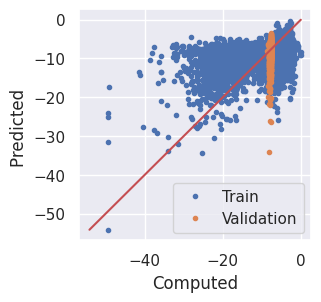

Epoch: 56, Train MAE: 2.9495, Val MAE: 1.4471
Epoch: 57, Train MAE: 2.9227, Val MAE: 1.6573
Epoch: 58, Train MAE: 2.9284, Val MAE: 1.5190
Epoch: 59, Train MAE: 2.9392, Val MAE: 1.6326
Epoch: 60, Train MAE: 2.9487, Val MAE: 1.6530


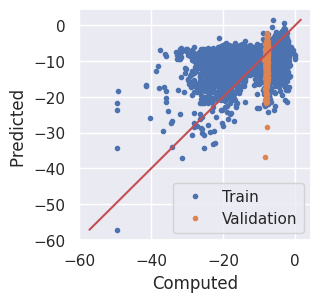

Epoch: 61, Train MAE: 2.9141, Val MAE: 1.6017
Epoch: 62, Train MAE: 2.9222, Val MAE: 1.6106
Epoch: 63, Train MAE: 2.9308, Val MAE: 1.5962
Epoch: 64, Train MAE: 2.9133, Val MAE: 1.6193
Epoch: 65, Train MAE: 2.9129, Val MAE: 1.6653


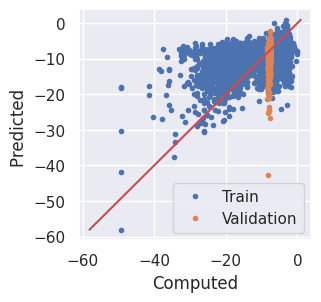

Epoch: 66, Train MAE: 2.8955, Val MAE: 1.5895
Epoch: 67, Train MAE: 2.9075, Val MAE: 1.7238
Epoch: 68, Train MAE: 2.8960, Val MAE: 1.5777
Epoch: 69, Train MAE: 2.9085, Val MAE: 1.6044
Epoch: 70, Train MAE: 2.9218, Val MAE: 1.6198


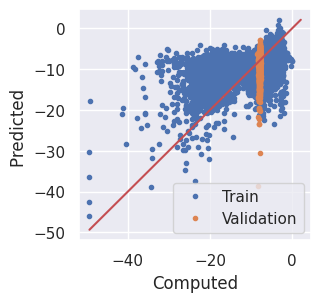

Epoch: 71, Train MAE: 2.8901, Val MAE: 1.5572
Epoch: 72, Train MAE: 2.8955, Val MAE: 1.8389
Epoch: 73, Train MAE: 2.9062, Val MAE: 1.6346
Epoch: 74, Train MAE: 2.8871, Val MAE: 1.7332
Epoch: 75, Train MAE: 2.8996, Val MAE: 1.6269


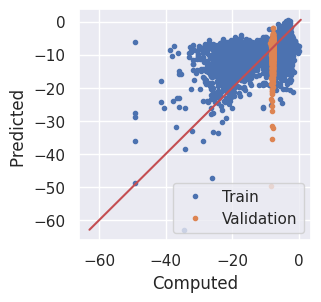

Epoch: 76, Train MAE: 2.9153, Val MAE: 1.8025
Epoch: 77, Train MAE: 2.8899, Val MAE: 1.7206
Epoch: 78, Train MAE: 2.8756, Val MAE: 1.6885
Epoch: 79, Train MAE: 2.8921, Val MAE: 1.5054
Epoch: 80, Train MAE: 2.8689, Val MAE: 1.6429


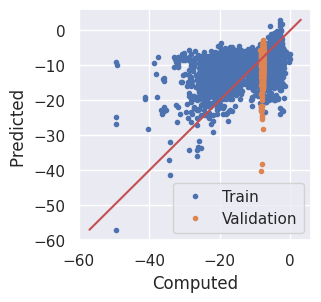

Epoch: 81, Train MAE: 2.8792, Val MAE: 1.6970
Epoch: 82, Train MAE: 2.8606, Val MAE: 1.6847
Epoch: 83, Train MAE: 2.8795, Val MAE: 1.6838
Epoch: 84, Train MAE: 2.8604, Val MAE: 1.8856
Epoch: 85, Train MAE: 2.8839, Val MAE: 1.7065


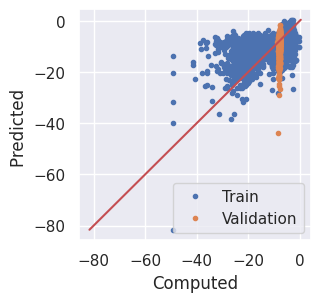

Epoch: 86, Train MAE: 2.8848, Val MAE: 1.8028
Epoch: 87, Train MAE: 2.8657, Val MAE: 1.7727
Epoch: 88, Train MAE: 2.8527, Val MAE: 1.7964
Epoch: 89, Train MAE: 2.8752, Val MAE: 1.6601
Epoch: 90, Train MAE: 2.8568, Val MAE: 1.6825


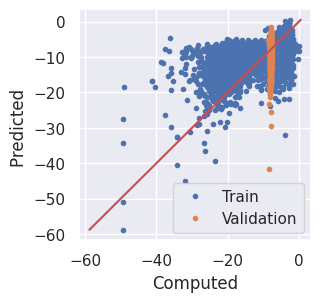

Epoch: 91, Train MAE: 2.8641, Val MAE: 1.6374
Epoch: 92, Train MAE: 2.8441, Val MAE: 1.5753
Epoch: 93, Train MAE: 2.8408, Val MAE: 1.7455
Epoch: 94, Train MAE: 2.8454, Val MAE: 1.7772
Epoch: 95, Train MAE: 2.8196, Val MAE: 1.7883


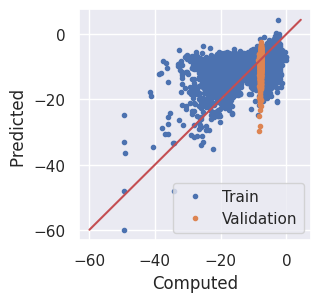

Epoch: 96, Train MAE: 2.8215, Val MAE: 1.6079
Epoch: 97, Train MAE: 2.8390, Val MAE: 1.7972
Epoch: 98, Train MAE: 2.8529, Val MAE: 1.7016
Epoch: 99, Train MAE: 2.8316, Val MAE: 1.8794
Epoch: 100, Train MAE: 2.8164, Val MAE: 1.7011


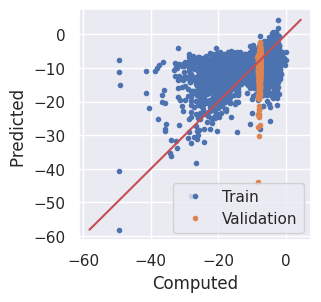

Epoch: 101, Train MAE: 2.8546, Val MAE: 1.7635
Epoch: 102, Train MAE: 2.8222, Val MAE: 1.6547
Epoch: 103, Train MAE: 2.8438, Val MAE: 1.8603
Epoch: 104, Train MAE: 2.8108, Val MAE: 1.7652
Epoch: 105, Train MAE: 2.8265, Val MAE: 1.8429


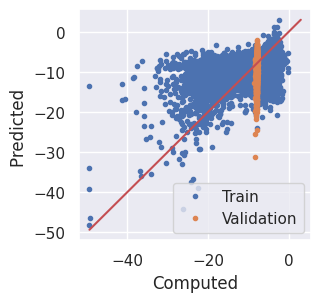

Epoch: 106, Train MAE: 2.8564, Val MAE: 1.6476
Epoch: 107, Train MAE: 2.8316, Val MAE: 1.8279
Epoch: 108, Train MAE: 2.8178, Val MAE: 1.7429
Epoch: 109, Train MAE: 2.8009, Val MAE: 1.8758
Epoch: 110, Train MAE: 2.8069, Val MAE: 1.8853


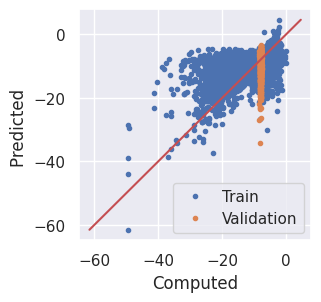

Epoch: 111, Train MAE: 2.8172, Val MAE: 1.7202
Epoch: 112, Train MAE: 2.8169, Val MAE: 1.8106
Epoch: 113, Train MAE: 2.8306, Val MAE: 1.8888
Epoch: 114, Train MAE: 2.7974, Val MAE: 1.7396
Epoch: 115, Train MAE: 2.7976, Val MAE: 1.8918


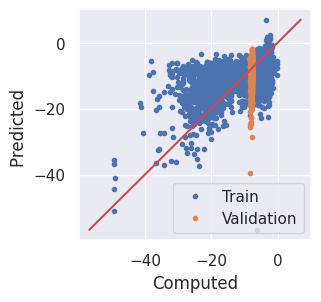

Epoch: 116, Train MAE: 2.8251, Val MAE: 1.8044
Epoch: 117, Train MAE: 2.7948, Val MAE: 1.7309
Epoch: 118, Train MAE: 2.7784, Val MAE: 1.6863
Epoch: 119, Train MAE: 2.7999, Val MAE: 1.9370
Epoch: 120, Train MAE: 2.8031, Val MAE: 1.8309


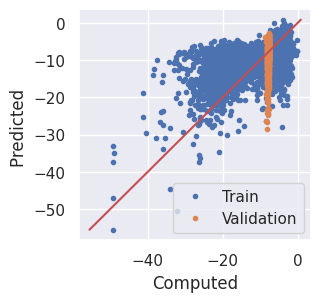

Epoch: 121, Train MAE: 2.8160, Val MAE: 1.8074
Epoch: 122, Train MAE: 2.7928, Val MAE: 1.8444
Epoch: 123, Train MAE: 2.7744, Val MAE: 1.8660
Epoch: 124, Train MAE: 2.7866, Val MAE: 1.7189
Epoch: 125, Train MAE: 2.7966, Val MAE: 1.7671


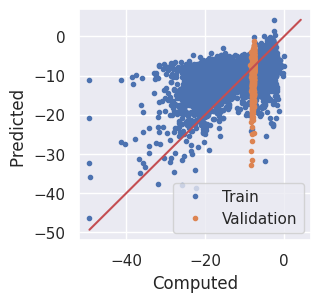

Epoch: 126, Train MAE: 2.7820, Val MAE: 1.7927
Epoch: 127, Train MAE: 2.7937, Val MAE: 1.7867
Epoch: 128, Train MAE: 2.7935, Val MAE: 1.8427
Epoch: 129, Train MAE: 2.7919, Val MAE: 1.7012
Epoch: 130, Train MAE: 2.7377, Val MAE: 1.8929


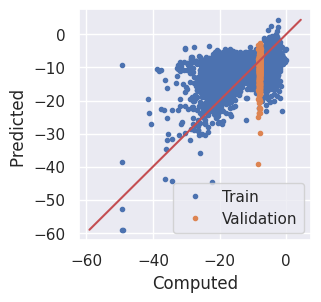

Epoch: 131, Train MAE: 2.7936, Val MAE: 1.7579
Epoch: 132, Train MAE: 2.7501, Val MAE: 1.8384
Epoch: 133, Train MAE: 2.7937, Val MAE: 1.8332
Epoch: 134, Train MAE: 2.7780, Val MAE: 1.8227
Epoch: 135, Train MAE: 2.7579, Val MAE: 1.8930


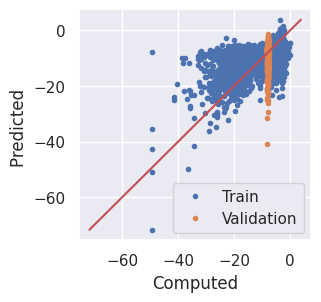

Epoch: 136, Train MAE: 2.7763, Val MAE: 1.7939
Epoch: 137, Train MAE: 2.7981, Val MAE: 1.9970
Epoch: 138, Train MAE: 2.7539, Val MAE: 1.8382
Epoch: 139, Train MAE: 2.7567, Val MAE: 1.9042
Epoch: 140, Train MAE: 2.7679, Val MAE: 1.9472


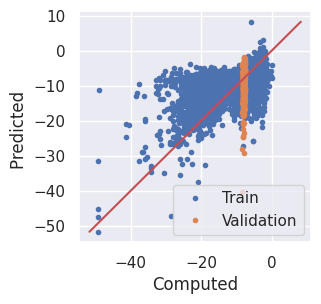

Epoch: 141, Train MAE: 2.7881, Val MAE: 1.7527
Epoch: 142, Train MAE: 2.7631, Val MAE: 1.9061
Epoch: 143, Train MAE: 2.7882, Val MAE: 1.8045
Epoch: 144, Train MAE: 2.7650, Val MAE: 1.8041
Epoch: 145, Train MAE: 2.7789, Val MAE: 1.6773


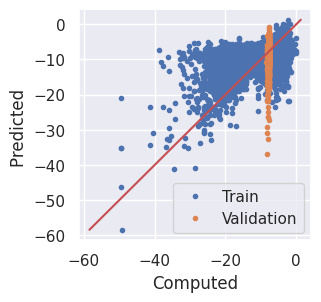

Epoch: 146, Train MAE: 2.7783, Val MAE: 1.8670
Epoch: 147, Train MAE: 2.7544, Val MAE: 1.8931
Epoch: 148, Train MAE: 2.7633, Val MAE: 1.6735
Epoch: 149, Train MAE: 2.7545, Val MAE: 1.8363
Epoch: 150, Train MAE: 2.7346, Val MAE: 1.9502


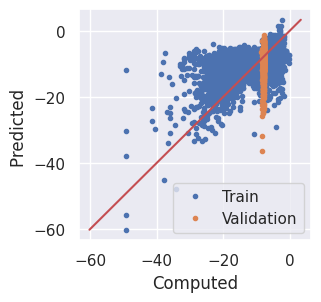

Epoch: 151, Train MAE: 2.7665, Val MAE: 1.8969
Epoch: 152, Train MAE: 2.7625, Val MAE: 1.8679
Epoch: 153, Train MAE: 2.7418, Val MAE: 1.9335
Epoch: 154, Train MAE: 2.7434, Val MAE: 1.8981
Epoch: 155, Train MAE: 2.7281, Val MAE: 1.8896


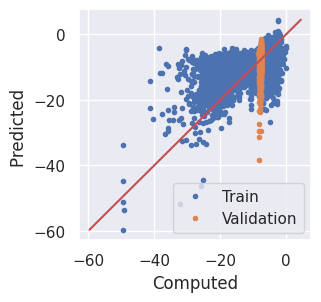

Epoch: 156, Train MAE: 2.7672, Val MAE: 1.8684
Epoch: 157, Train MAE: 2.7405, Val MAE: 1.8478
Epoch: 158, Train MAE: 2.7351, Val MAE: 1.9421
Epoch: 159, Train MAE: 2.7485, Val MAE: 1.9250
Epoch: 160, Train MAE: 2.7212, Val MAE: 1.8862


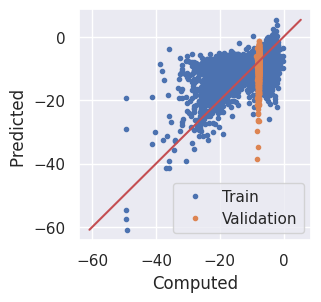

Epoch: 161, Train MAE: 2.7214, Val MAE: 1.9471
Epoch: 162, Train MAE: 2.7353, Val MAE: 1.9306
Epoch: 163, Train MAE: 2.7404, Val MAE: 1.8409
Epoch: 164, Train MAE: 2.7946, Val MAE: 1.6517
Epoch: 165, Train MAE: 2.8018, Val MAE: 2.0244


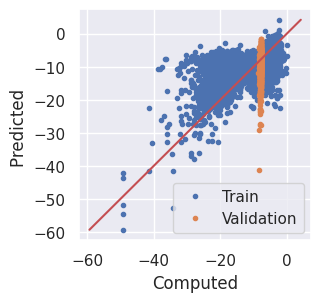

Epoch: 166, Train MAE: 2.7243, Val MAE: 1.9622
Epoch: 167, Train MAE: 2.7247, Val MAE: 1.9275
Epoch: 168, Train MAE: 2.7245, Val MAE: 1.9744
Epoch: 169, Train MAE: 2.7169, Val MAE: 1.9201
Epoch: 170, Train MAE: 2.7136, Val MAE: 1.9758


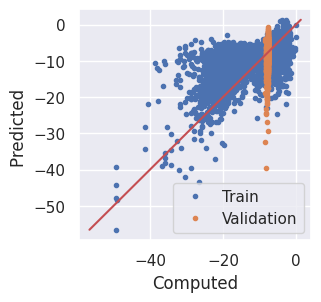

Epoch: 171, Train MAE: 2.7093, Val MAE: 1.8527
Epoch: 172, Train MAE: 2.7151, Val MAE: 1.8834
Epoch: 173, Train MAE: 2.7252, Val MAE: 1.9179
Epoch: 174, Train MAE: 2.7205, Val MAE: 1.8352
Epoch: 175, Train MAE: 2.7276, Val MAE: 2.2107


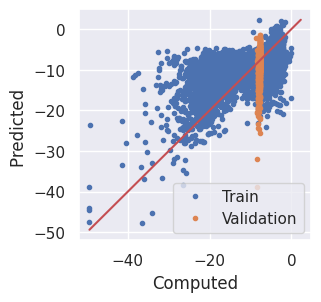

Epoch: 176, Train MAE: 2.7056, Val MAE: 1.8563
Epoch: 177, Train MAE: 2.7354, Val MAE: 1.8996
Epoch: 178, Train MAE: 2.7356, Val MAE: 1.8378
Epoch: 179, Train MAE: 2.7450, Val MAE: 1.8563
Epoch: 180, Train MAE: 2.7305, Val MAE: 1.9351


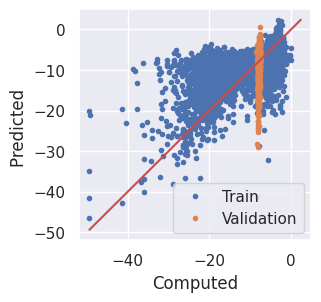

Epoch: 181, Train MAE: 2.7208, Val MAE: 1.8669
Epoch: 182, Train MAE: 2.7253, Val MAE: 1.8321
Epoch: 183, Train MAE: 2.7068, Val MAE: 1.8491
Epoch: 184, Train MAE: 2.7183, Val MAE: 1.8708
Epoch: 185, Train MAE: 2.7271, Val MAE: 1.8475


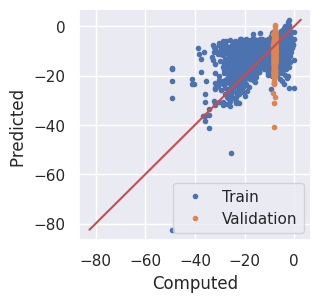

Epoch: 186, Train MAE: 2.7420, Val MAE: 1.8426
Epoch: 187, Train MAE: 2.7408, Val MAE: 1.9453
Epoch: 188, Train MAE: 2.6767, Val MAE: 1.9745
Epoch: 189, Train MAE: 2.6960, Val MAE: 1.8583
Epoch: 190, Train MAE: 2.7020, Val MAE: 1.8655


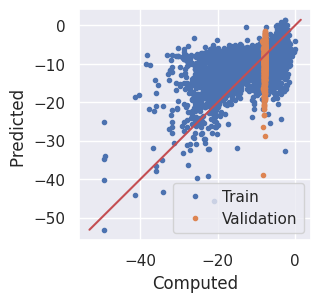

Epoch: 191, Train MAE: 2.7312, Val MAE: 1.8290
Epoch: 192, Train MAE: 2.6907, Val MAE: 1.9257
Epoch: 193, Train MAE: 2.7138, Val MAE: 1.9310
Epoch: 194, Train MAE: 2.7033, Val MAE: 1.9942
Epoch: 195, Train MAE: 2.7198, Val MAE: 1.9186


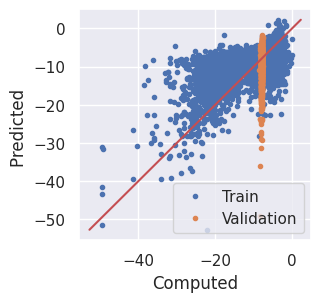

Epoch: 196, Train MAE: 2.6987, Val MAE: 2.1289
Epoch: 197, Train MAE: 2.7164, Val MAE: 1.8657
Epoch: 198, Train MAE: 2.7003, Val MAE: 1.8810
Epoch: 199, Train MAE: 2.7204, Val MAE: 1.8103
Epoch: 200, Train MAE: 2.6907, Val MAE: 1.7772


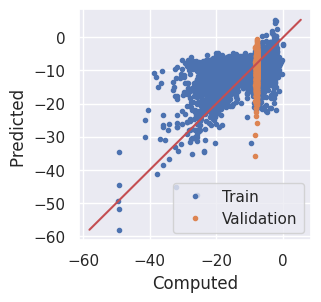

Epoch: 201, Train MAE: 2.6884, Val MAE: 1.8221
Epoch: 202, Train MAE: 2.7180, Val MAE: 1.9181
Epoch: 203, Train MAE: 2.6937, Val MAE: 1.9928
Epoch: 204, Train MAE: 2.6983, Val MAE: 1.9220
Epoch: 205, Train MAE: 2.7153, Val MAE: 1.8603


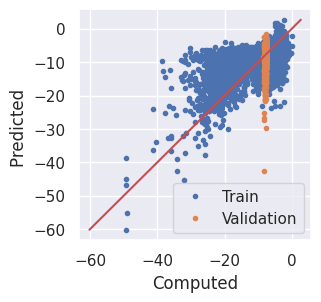

Epoch: 206, Train MAE: 2.6774, Val MAE: 1.8639
Epoch: 207, Train MAE: 2.6712, Val MAE: 1.9909
Epoch: 208, Train MAE: 2.7198, Val MAE: 2.0212
Epoch: 209, Train MAE: 2.6993, Val MAE: 2.0656
Epoch: 210, Train MAE: 2.6827, Val MAE: 1.8792


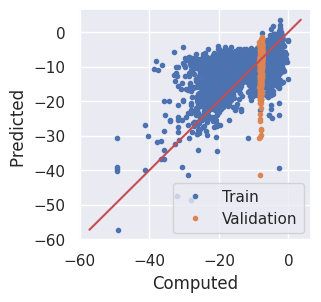

Epoch: 211, Train MAE: 2.6961, Val MAE: 1.9029
Epoch: 212, Train MAE: 2.7082, Val MAE: 1.9008
Epoch: 213, Train MAE: 2.6850, Val MAE: 1.8697
Epoch: 214, Train MAE: 2.6949, Val MAE: 1.8243
Epoch: 215, Train MAE: 2.6860, Val MAE: 1.9411


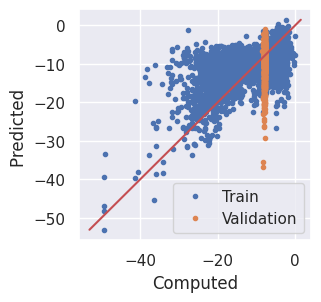

Epoch: 216, Train MAE: 2.6814, Val MAE: 2.0522
Epoch: 217, Train MAE: 2.7074, Val MAE: 1.8031
Epoch: 218, Train MAE: 2.6944, Val MAE: 1.8051
Epoch: 219, Train MAE: 2.7028, Val MAE: 1.9662
Epoch: 220, Train MAE: 2.6880, Val MAE: 1.8673


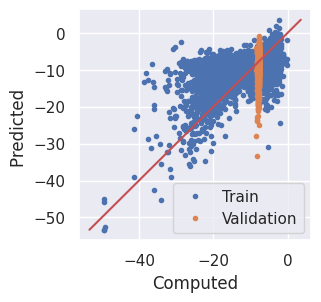

Epoch: 221, Train MAE: 2.6789, Val MAE: 1.8063
Epoch: 222, Train MAE: 2.6582, Val MAE: 1.9473
Epoch: 223, Train MAE: 2.6806, Val MAE: 1.8728
Epoch: 224, Train MAE: 2.6910, Val MAE: 2.0432
Epoch: 225, Train MAE: 2.7048, Val MAE: 1.8360


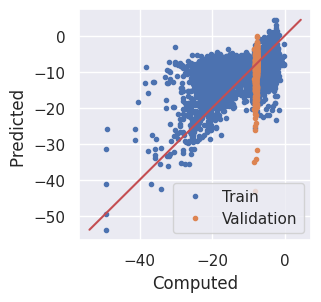

Epoch: 226, Train MAE: 2.6869, Val MAE: 1.9525
Epoch: 227, Train MAE: 2.7113, Val MAE: 1.8567
Epoch: 228, Train MAE: 2.7025, Val MAE: 1.9080
Epoch: 229, Train MAE: 2.6899, Val MAE: 1.8979
Epoch: 230, Train MAE: 2.7073, Val MAE: 1.9978


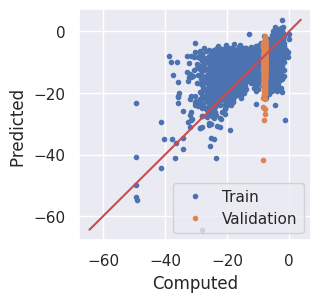

Epoch: 231, Train MAE: 2.6934, Val MAE: 1.8454
Epoch: 232, Train MAE: 2.7036, Val MAE: 1.9046
Epoch: 233, Train MAE: 2.6769, Val MAE: 1.9084
Epoch: 234, Train MAE: 2.6789, Val MAE: 1.8603
Epoch: 235, Train MAE: 2.6797, Val MAE: 1.8944


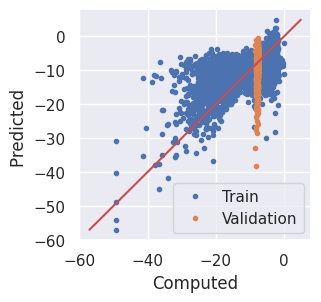

Epoch: 236, Train MAE: 2.6893, Val MAE: 2.0390
Epoch: 237, Train MAE: 2.6811, Val MAE: 1.9990
Epoch: 238, Train MAE: 2.6807, Val MAE: 1.9861
Epoch: 239, Train MAE: 2.6796, Val MAE: 1.8502
Epoch: 240, Train MAE: 2.6972, Val MAE: 1.8568


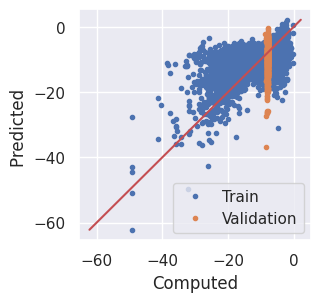

Epoch: 241, Train MAE: 2.6982, Val MAE: 1.9489
Epoch: 242, Train MAE: 2.6683, Val MAE: 1.8942
Epoch: 243, Train MAE: 2.6757, Val MAE: 1.9217
Epoch: 244, Train MAE: 2.6640, Val MAE: 2.0165
Epoch: 245, Train MAE: 2.6471, Val MAE: 1.9565


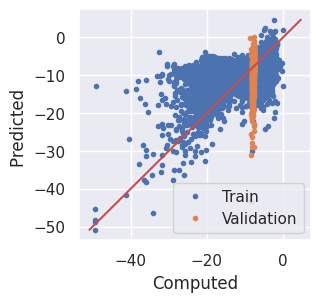

Epoch: 246, Train MAE: 2.6663, Val MAE: 2.0150
Epoch: 247, Train MAE: 2.6702, Val MAE: 1.9462
Epoch: 248, Train MAE: 2.6759, Val MAE: 2.0524
Epoch: 249, Train MAE: 2.6628, Val MAE: 1.8701
Epoch: 250, Train MAE: 2.6506, Val MAE: 1.9749


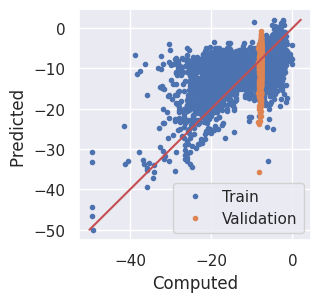

Epoch: 251, Train MAE: 2.6689, Val MAE: 1.8060
Epoch: 252, Train MAE: 2.6674, Val MAE: 2.2417
Epoch: 253, Train MAE: 2.6717, Val MAE: 1.9223
Epoch: 254, Train MAE: 2.6444, Val MAE: 1.8331
Epoch: 255, Train MAE: 2.6477, Val MAE: 1.8279


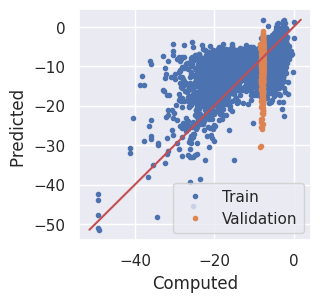

Epoch: 256, Train MAE: 2.6472, Val MAE: 1.8712
Epoch: 257, Train MAE: 2.6411, Val MAE: 2.0605
Epoch: 258, Train MAE: 2.6680, Val MAE: 1.8385
Epoch: 259, Train MAE: 2.6789, Val MAE: 1.8146
Epoch: 260, Train MAE: 2.6977, Val MAE: 1.8561


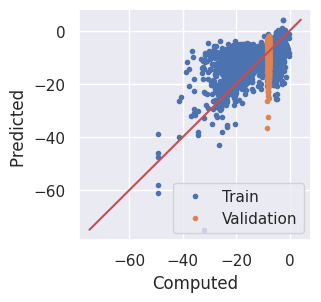

Epoch: 261, Train MAE: 2.6859, Val MAE: 1.9120
Epoch: 262, Train MAE: 2.6548, Val MAE: 1.8978
Epoch: 263, Train MAE: 2.6557, Val MAE: 1.9134
Epoch: 264, Train MAE: 2.6786, Val MAE: 1.7664
Epoch: 265, Train MAE: 2.6755, Val MAE: 1.9013


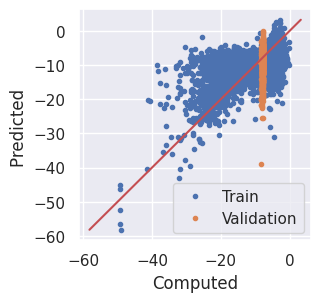

Epoch: 266, Train MAE: 2.6672, Val MAE: 1.9690
Epoch: 267, Train MAE: 2.6446, Val MAE: 1.9428
Epoch: 268, Train MAE: 2.6586, Val MAE: 1.8770
Epoch: 269, Train MAE: 2.6525, Val MAE: 2.0650
Epoch: 270, Train MAE: 2.6569, Val MAE: 2.1366


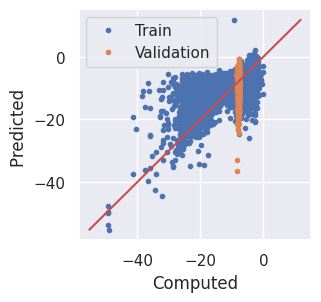

Epoch: 271, Train MAE: 2.6596, Val MAE: 1.7938
Epoch: 272, Train MAE: 2.6755, Val MAE: 1.9042
Epoch: 273, Train MAE: 2.6544, Val MAE: 1.8457
Epoch: 274, Train MAE: 2.6437, Val MAE: 1.9852
Epoch: 275, Train MAE: 2.6675, Val MAE: 1.8792


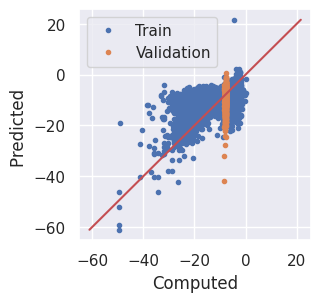

Epoch: 276, Train MAE: 2.6439, Val MAE: 1.9312
Epoch: 277, Train MAE: 2.6350, Val MAE: 1.9532
Epoch: 278, Train MAE: 2.6994, Val MAE: 1.8510
Epoch: 279, Train MAE: 2.6601, Val MAE: 1.8245
Epoch: 280, Train MAE: 2.6239, Val MAE: 2.0161


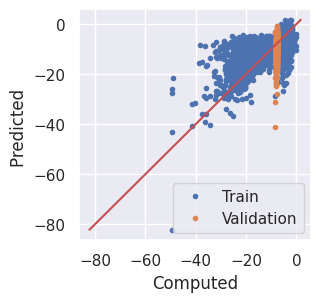

Epoch: 281, Train MAE: 2.6636, Val MAE: 1.9040
Epoch: 282, Train MAE: 2.6363, Val MAE: 2.0747
Epoch: 283, Train MAE: 2.6298, Val MAE: 1.9550
Epoch: 284, Train MAE: 2.6233, Val MAE: 1.9097
Epoch: 285, Train MAE: 2.6631, Val MAE: 1.9295


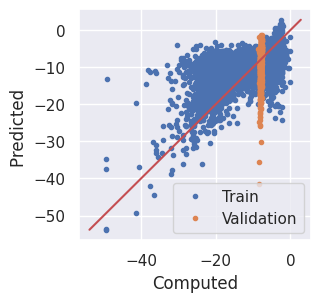

Epoch: 286, Train MAE: 2.6433, Val MAE: 1.9889
Epoch: 287, Train MAE: 2.6497, Val MAE: 2.0549
Epoch: 288, Train MAE: 2.6230, Val MAE: 1.6688
Epoch: 289, Train MAE: 2.6943, Val MAE: 2.0651
Epoch: 290, Train MAE: 2.6488, Val MAE: 1.8285


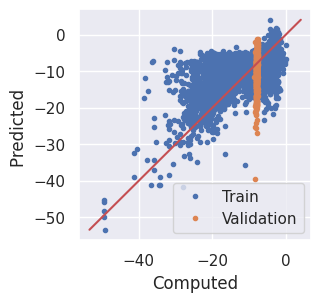

Epoch: 291, Train MAE: 2.6206, Val MAE: 1.9170
Epoch: 292, Train MAE: 2.6230, Val MAE: 2.0050
Epoch: 293, Train MAE: 2.6363, Val MAE: 1.9174
Epoch: 294, Train MAE: 2.6355, Val MAE: 1.8203
Epoch: 295, Train MAE: 2.6873, Val MAE: 1.9039


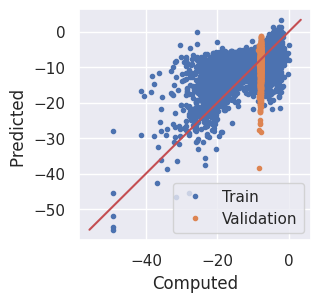

Epoch: 296, Train MAE: 2.6391, Val MAE: 1.9988
Epoch: 297, Train MAE: 2.6380, Val MAE: 1.9938
Epoch: 298, Train MAE: 2.6172, Val MAE: 2.0366
Epoch: 299, Train MAE: 2.6576, Val MAE: 2.0343
Epoch: 300, Train MAE: 2.6718, Val MAE: 2.0094


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

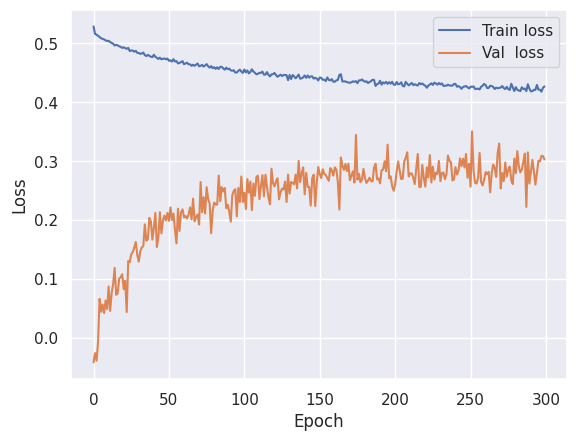

In [10]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [11]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(files_names['model_name'], map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

/tmp/ipykernel_527588/1424548799.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(files_names['model_name'], map_location=torch.device(de

GCNN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 32)
  (linconv1): Linear(in_features=32, out_features=32, bias=True)
  (linconv2): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

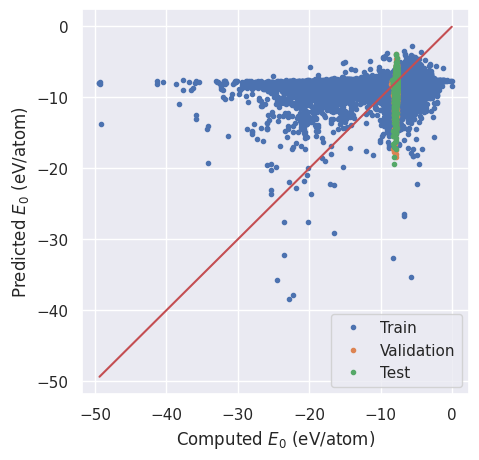

Train MAE: 3.2827, Val MAE: 0.9090, Test MAE: 0.9305


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor.to(device),
                                                              standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [19]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor.to(device),
                                            standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

array([-0.43063354,  4.594536  , -4.8845205 , ...,  0.36291742,
        0.02323961, -0.08671331], dtype=float32)

In [20]:
# Generate dictionary with uncertainty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(files_names['uncert_data_name'], 'w') as json_file:
    json.dump(uncertainty_data, json_file)